# **Instructions for Assignment 7**
*Hyperparameter Tuning of a Deep MLP on the MNIST Dataset Using Keras Tuner*

In this assignment, you will work with the MNIST dataset to develop a deep Multi-Layer Perceptron (MLP) model. Using Keras Tuner, you will search for the best hyperparameters to optimize the MLP model's performance, aiming to achieve a test accuracy of at least 98%. Your task is to explore different configurations of the MLP model, analyze the tuning results, and identify the optimal hyperparameter values.

Assignment Instructions:

- **Train a Deep MLP Model on the MNIST Dataset:** Set up a deep MLP model for classifying handwritten digits from the MNIST dataset. 

- **Hyperparameter Tuning with Keras Tuner:** Use Keras Tuner to perform hyperparameter tuning on the model. Search for optimal values of key hyperparameters, such as, number of Hidden Layers and units in a hidden layer, learning rate, and batch size. Configure Keras Tuner to use Random Search to find the best hyperparameter values.

- **Analyze the Tuning Results:** Once tuning is complete, evaluate the model’s performance with the best-found hyperparameters on the test set. Present results, including metrics such as accuracy, training time, and convergence rate. Discuss the chosen hyperparameters and explain how they contributed to achieving high accuracy on the MNIST dataset.

- **Comparison with Baseline Model (Optional)**
Optionally, compare the tuned MLP model's accuracy with the models we used for classification in our early labs on classification for MNIST dataset. Analyze and discuss the improvement in the performance.

<span style="color:red; font-weight:bold;">IMPORTANT INFORMATION:</span>

This notebook contains the code used to obtain the results from the lab report.  
However, it is important to highlight that it migth not reproduce the *exact same results*,  
since it was re-run later without saving the previous version.
ed but it is not included here. 

I could have done a grid search that would narrow better the results allowing a better reproduction of the process, but it was not asked in the assigment and I have done it many times before.

## **Import libraries and dataset**

In [3]:
# ======================================================
# Deep MLP on MNIST + Hyperparameter Tuning with Keras Tuner
# ======================================================

import sys
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import time

# --- Version checks ---
assert sys.version_info >= (3, 6)
assert tf.__version__ >= "2.0"

# --- Reproducibility ---
np.random.seed(42)
tf.random.set_seed(42)

# --- Load MNIST dataset ---
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

# Normalize (0–255) → (0–1)
X_train_full = X_train_full.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# Split validation set
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

## **Build a plane simple model**

In [4]:
# --- Baseline (before tuning) ---
baseline_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
baseline_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

t0 = time.time()
baseline_history = baseline_model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_valid, y_valid),
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
    verbose=0
)
baseline_time = time.time() - t0

baseline_test_loss, baseline_test_acc = baseline_model.evaluate(X_test, y_test)
print(f"📊Baseline Test Accuracy: {baseline_test_acc:.4f}")
print(f"📉Baseline Test loss: {baseline_test_loss:.4f}")
print(f"Baseline Training Time: {baseline_time:.2f}s")

C:\Users\pablo\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.9730 - loss: 0.1293
📊Baseline Test Accuracy: 0.9730
📉Baseline Test loss: 0.1293
Baseline Training Time: 32.15s


Lets look to the learning curves:

<Figure size 800x500 with 0 Axes>

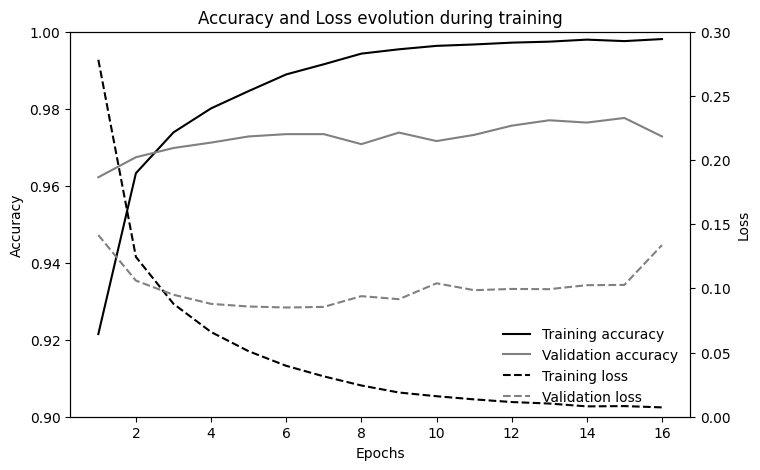

In [16]:
plt.figure(figsize=(8,5))

epochs = range(1, len(baseline_history.history["accuracy"]) + 1)

fig, ax1 = plt.subplots(figsize=(8,5))

# Accuracy (Y1)
ax1.plot(epochs, baseline_history.history["accuracy"], color="black", label="Training accuracy")
ax1.plot(epochs, baseline_history.history["val_accuracy"], color="gray", label="Validation accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_ylim(0.90, 1.0)

# Loss (Y2)
ax2 = ax1.twinx()
ax2.plot(epochs, baseline_history.history["loss"], color="black", linestyle="dashed", label="Training loss")
ax2.plot(epochs, baseline_history.history["val_loss"], color="gray", linestyle="dashed", label="Validation loss")
ax2.set_ylabel("Loss")
ax2.set_ylim(0, 0.3)

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="lower right", frameon=False)

plt.title("Accuracy and Loss evolution during training")
plt.show()


As the plot show... there is a huge overfitting of the training set what means we should regularizate the model.

## **Build model function for Keras Tuner**

In [6]:
# --- Build model function for Keras Tuner ---
def build_model(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28, 28]))

    # Tune hidden layers
    n_hidden = hp.Int("n_hidden", min_value=2, max_value=4, step=1)
    for i in range(n_hidden):
        units = hp.Int(f"units_{i}", min_value=15, max_value=256, step=25)
        model.add(keras.layers.Dense(units, activation="relu"))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dropout(rate=hp.Float(f"dropout_{i}", 0.2, 0.5, step=0.1)))

    model.add(keras.layers.Dense(10, activation="softmax"))

    # Tune optimizer and learning rate
    learning_rate = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
    optimizer_choice = hp.Choice("optimizer", ["adam", "rmsprop"])
    if optimizer_choice == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# --- Set up Keras Tuner ---
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=30,          
    executions_per_trial=1,
    directory="mnist_tuning",
    project_name="mlp_optimized"
)

## **Perform hyperparameter search**

In [ ]:
# --- Perform hyperparameter search ---

tuner.search(
    X_train, y_train,
    epochs=50,
    validation_data=(X_valid, y_valid),
    callbacks=[keras.callbacks.EarlyStopping(patience=10)]
)

# --- Retrieve the best model ---
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n✅ Best Hyperparameters Found:")
print(f"Number of hidden layers: {best_hps.get('n_hidden')}")
for i in range(best_hps.get('n_hidden')):
    print(f" - Units in layer {i+1}: {best_hps.get(f'units_{i}')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")

Trial 30 Complete [00h 03m 15s]
val_accuracy: 0.972000002861023

Best val_accuracy So Far: 0.9837999939918518
Total elapsed time: 01h 13m 49s

✅ Best Hyperparameters Found:
Number of hidden layers: 2
 - Units in layer 1: 240
 - Units in layer 2: 115
Learning rate: 0.00015821813975456654


C:\Users\pablo\AppData\Roaming\Python\Python313\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [23]:
print(f"Optimizer: {best_hps.get('optimizer')}")


Optimizer: adam


## **Train the best model on the full training data**

In [8]:
# --- Train the best model on the full training data ---
t1 = time.time()
history = best_model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_valid, y_valid),
    callbacks=[keras.callbacks.EarlyStopping(patience=10)]
)
tuned_time = time.time() - t1

Epoch 1/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9894 - loss: 0.0328 - val_accuracy: 0.9842 - val_loss: 0.0717
Epoch 2/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9895 - loss: 0.0321 - val_accuracy: 0.9816 - val_loss: 0.0739
Epoch 3/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9895 - loss: 0.0319 - val_accuracy: 0.9826 - val_loss: 0.0708
Epoch 4/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9895 - loss: 0.0306 - val_accuracy: 0.9822 - val_loss: 0.0731
Epoch 5/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9906 - loss: 0.0279 - val_accuracy: 0.9832 - val_loss: 0.0700
Epoch 6/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9905 - loss: 0.0285 - val_accuracy: 0.9832 - val_loss: 0.0765
Epoch 7/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9909 - loss: 0.0267 - val_accuracy: 0.9828 - val_loss: 0.0678
Epoch 8/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9909 - loss: 0.0266 - 

## **Evaluate on test set**

In [9]:
# --- Evaluate on test set ---
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"\n📊 Test accuracy: {test_acc:.4f}")
print(f"📉 Test loss: {test_loss:.4f}")
print(f"Tuned Training Time: {tuned_time:.2f}s")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9835 - loss: 0.0720

📊 Test accuracy: 0.9835
📉 Test loss: 0.0720
Tuned Training Time: 98.75s


Lets look to the learning curve:

<Figure size 800x500 with 0 Axes>

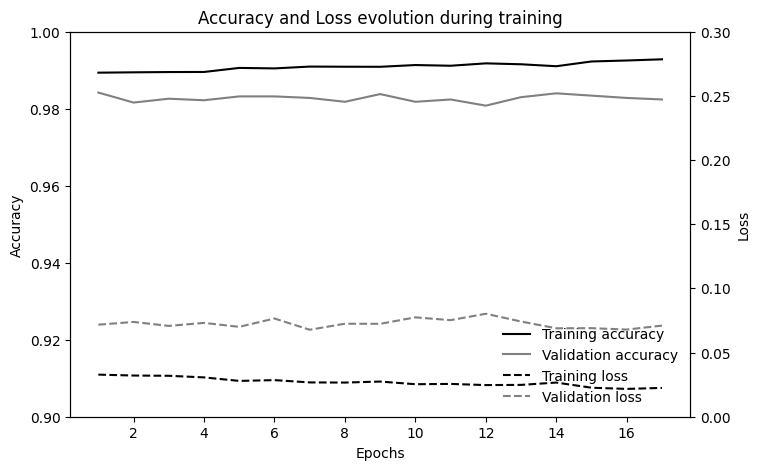

In [17]:
plt.figure(figsize=(8,5))

epochs = range(1, len(history.history["accuracy"]) + 1)

fig, ax1 = plt.subplots(figsize=(8,5))

# Accuracy (Y1)
ax1.plot(epochs, history.history["accuracy"], color="black", label="Training accuracy")
ax1.plot(epochs, history.history["val_accuracy"], color="gray", label="Validation accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_ylim(0.90, 1.0)

# Loss (Y2)
ax2 = ax1.twinx()
ax2.plot(epochs, history.history["loss"], color="black", linestyle="dashed", label="Training loss")
ax2.plot(epochs, history.history["val_loss"], color="gray", linestyle="dashed", label="Validation loss")
ax2.set_ylabel("Loss")
ax2.set_ylim(0, 0.3)

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="lower right", frameon=False)

plt.title("Accuracy and Loss evolution during training")
plt.show()


## **Visualitation and analysis**

### Compare

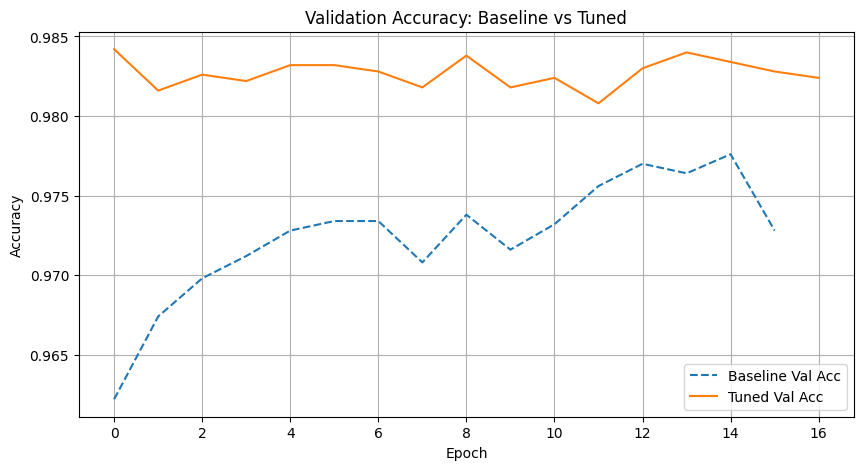

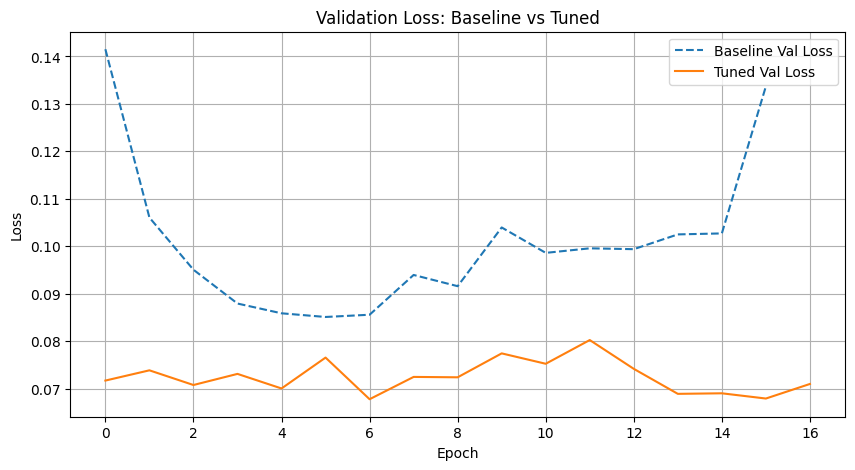

In [11]:
# --- Plot comparison of accuracy and loss ---
plt.figure(figsize=(10,5))
plt.plot(baseline_history.history['val_accuracy'], label='Baseline Val Acc', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Tuned Val Acc', linestyle='-')
plt.title('Validation Accuracy: Baseline vs Tuned')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(baseline_history.history['val_loss'], label='Baseline Val Loss', linestyle='--')
plt.plot(history.history['val_loss'], label='Tuned Val Loss', linestyle='-')
plt.title('Validation Loss: Baseline vs Tuned')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### Wanted to show how the accruacy value for the randomsearch trials change as the hyperparameters change:

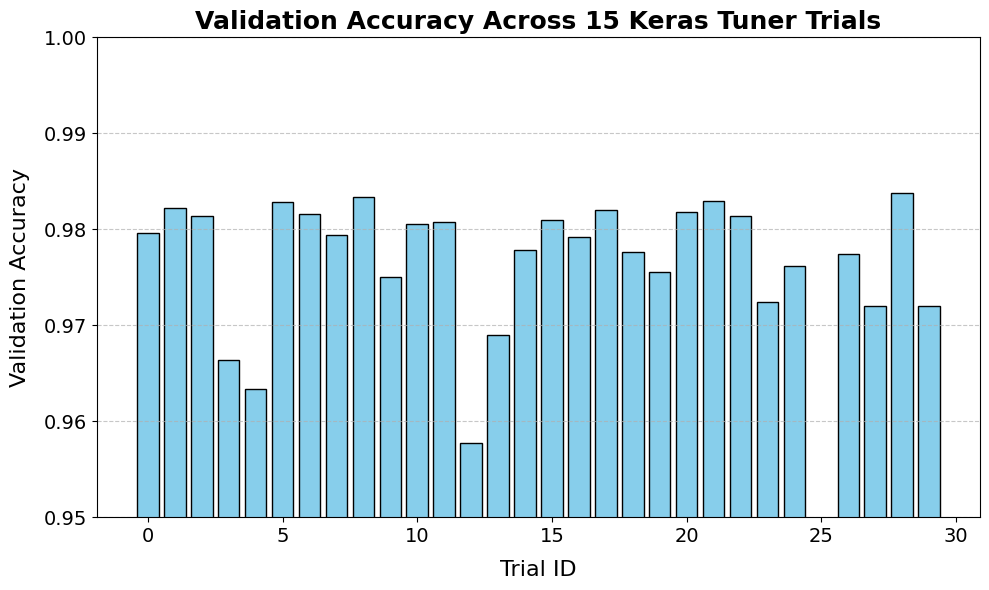

    Trial  Validation Accuracy
0       0               0.9796
1       1               0.9822
2       2               0.9814
3       3               0.9664
4       4               0.9634
5       5               0.9828
6       6               0.9816
7       7               0.9794
8       8               0.9834
9       9               0.9750
10     10               0.9806
11     11               0.9808
12     12               0.9578
13     13               0.9690
14     14               0.9778
15     15               0.9810
16     16               0.9792
17     17               0.9820
18     18               0.9776
19     19               0.9756
20     20               0.9818
21     21               0.9830
22     22               0.9814
23     23               0.9724
24     24               0.9762
25     25               0.9456
26     26               0.9774
27     27               0.9720
28     28               0.9838
29     29               0.9720


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Get trials in the order they were run
all_trials = list(tuner.oracle.trials.values())
all_trials = sorted(all_trials, key=lambda t: int(t.trial_id))  # sort numerically

val_accuracies = [t.metrics.get_last_value('val_accuracy') for t in all_trials]
trial_ids = [int(t.trial_id) for t in all_trials]

# Create a DataFrame for clarity
df = pd.DataFrame({
    'Trial': trial_ids,
    'Validation Accuracy': val_accuracies
})

# --- Plot with larger axis values ---
plt.figure(figsize=(10,6))
plt.bar(df['Trial'], df['Validation Accuracy'], color='skyblue', edgecolor='black')

plt.title('Validation Accuracy Across 15 Keras Tuner Trials', fontsize=18, fontweight='bold')
plt.xlabel('Trial ID', fontsize=16, labelpad=10)
plt.ylabel('Validation Accuracy', fontsize=16, labelpad=10)

# Make tick labels larger
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Grid and limits
plt.ylim(0.95, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Print the sorted results
print(df)



### Here I just prepare a data set with the information of the trials, I wanted to look deeper into it and find if there is interesting correlations between the features and the validation accuracy.

In [13]:
# Get all trials
trials = tuner.oracle.trials.values()

# Extract relevant information
records = []
for t in trials:
    trial_id = t.trial_id
    metrics = t.metrics.get_last_value("val_accuracy")
    params = t.hyperparameters.values
    params["trial_id"] = trial_id
    params["val_accuracy"] = metrics
    records.append(params)

# Create DataFrame
df_params = pd.DataFrame(records)

# Sort by best accuracy
df_params = df_params.sort_values(by="val_accuracy", ascending=False).reset_index(drop=True)



### Plot the correlations between all the parameters including the validation accuracy.

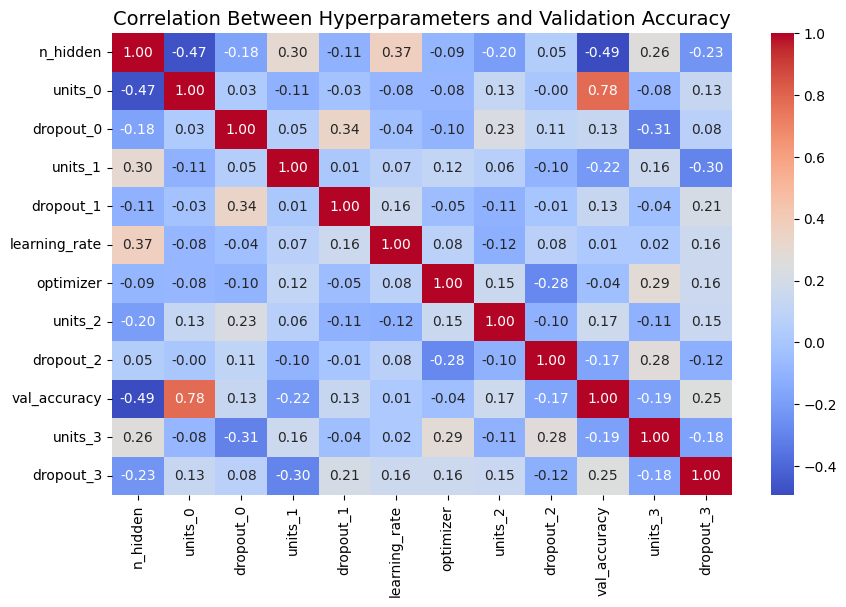

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert categorical optimizer names to numeric for correlation
df_corr = df_params.copy()
df_corr["optimizer"] = df_corr["optimizer"].astype("category").cat.codes

# Compute correlation
corr = df_corr.corr(numeric_only=True)

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Hyperparameters and Validation Accuracy", fontsize=14)
plt.show()


The just plotted heatmap migth have some interesintg value but maybe to much mess... 


### Since last plot was a bit to much information, I decided to separate and as I wanted just plot the correlation of the parameters and validation accuracy:

C:\Users\pablo\AppData\Local\Temp\ipykernel_17004\2859265304.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=val_corr.values, y=val_corr.index, palette="coolwarm")


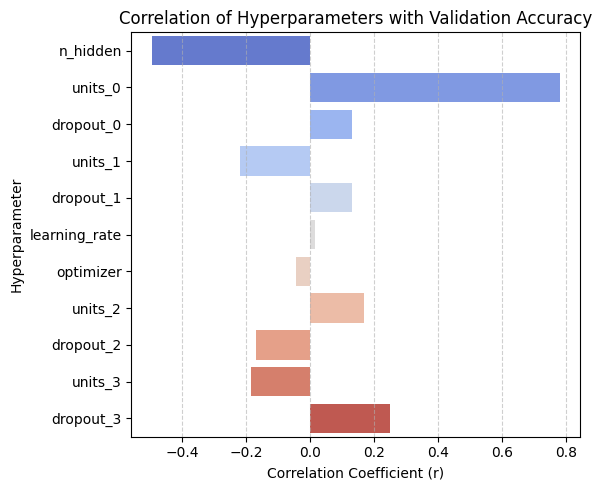

In [15]:
# Use the dataframe that contains all hyperparameters and 'val_accuracy'
# (the notebook stores that as `df_params`)
df_num = df_params.copy()

# Convert categorical optimizer to numeric codes so it can be included in correlations
if "optimizer" in df_num.columns:
	df_num["optimizer"] = df_num["optimizer"].astype("category").cat.codes

# Look for a column that represents validation accuracy (robust to naming)
val_candidates = ["val_accuracy", "Validation Accuracy", "val accuracy", "val_acc"]
val_col = next((c for c in val_candidates if c in df_num.columns), None)
if val_col is None:
	raise KeyError("No column named 'val_accuracy' or equivalent found in df_params")

# Compute correlations using numeric columns
corr = df_num.corr(numeric_only=True)

# Select correlations with the validation accuracy column (drop self-correlation)
val_corr = corr[val_col].drop(labels=[val_col], errors="ignore")

# --- Plot ---
plt.figure(figsize=(6, 5))
sns.barplot(x=val_corr.values, y=val_corr.index, palette="coolwarm")

plt.title("Correlation of Hyperparameters with Validation Accuracy")
plt.xlabel("Correlation Coefficient (r)")
plt.ylabel("Hyperparameter")
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


This one is actually really interesting... It shows that the layer 0 units are higly correllated, also the units for the layer 1, and the number of hidden layers ! :O cool stufs haha